In [1]:
import math
from collections import defaultdict
from typing import Tuple, Dict

from mono_job_data_preprocess import *
from object import CompCapacity, to_normalized_comp, to_real_comp

In [2]:

grid_plot_font = 24
grid_plot_row = 2
grid_plot_col = 4
grid_plot_width = 32
# grid_plot_height = 7
grid_plot_height = 8
grid_plot_legend_pot = (0.01, 0.897)
grid_plot_top = 0.83

In [3]:

data_source = get_data_source()

/Users/purchaser/PycharmProjects/MMKP-solver/data_source.py:58: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.most_memory_consumption: int = stats.mode(memories)[0][0]


ModelName.YoloV5N defaultdict(<class 'list'>, {1: [(3041918976, 2.8330078125), (4927258624, 4.5888671875), (8664383488, 8.0693359375)]})
ModelName.YoloV5N defaultdict(<function plot_mono_job_memory_spread_compare_absolute.<locals>.<lambda> at 0x2a8ff2dd0>, {0: defaultdict(<class 'list'>, {2: [(2094006272, 1.9501953125), (3041918976, 2.8330078125), (4927258624, 4.5888671875)], 4: [(1628438528, 1.5166015625), (2094006272, 1.9501953125), (3041918976, 2.8330078125)]})})
ModelName.YoloV5S defaultdict(<class 'list'>, {1: [(3213885440, 2.9931640625), (4749000704, 4.4228515625), (8603566080, 8.0126953125)]})
ModelName.YoloV5S defaultdict(<function plot_mono_job_memory_spread_compare_absolute.<locals>.<lambda> at 0x2a8ff2dd0>, {0: defaultdict(<class 'list'>, {2: [(2091909120, 1.9482421875), (3213885440, 2.9931640625), (4749000704, 4.4228515625)], 4: [(1674575872, 1.5595703125), (2091909120, 1.9482421875), (3213885440, 2.9931640625)]})})
ModelName.ConvNeXtT defaultdict(<class 'list'>, {1: [(3650

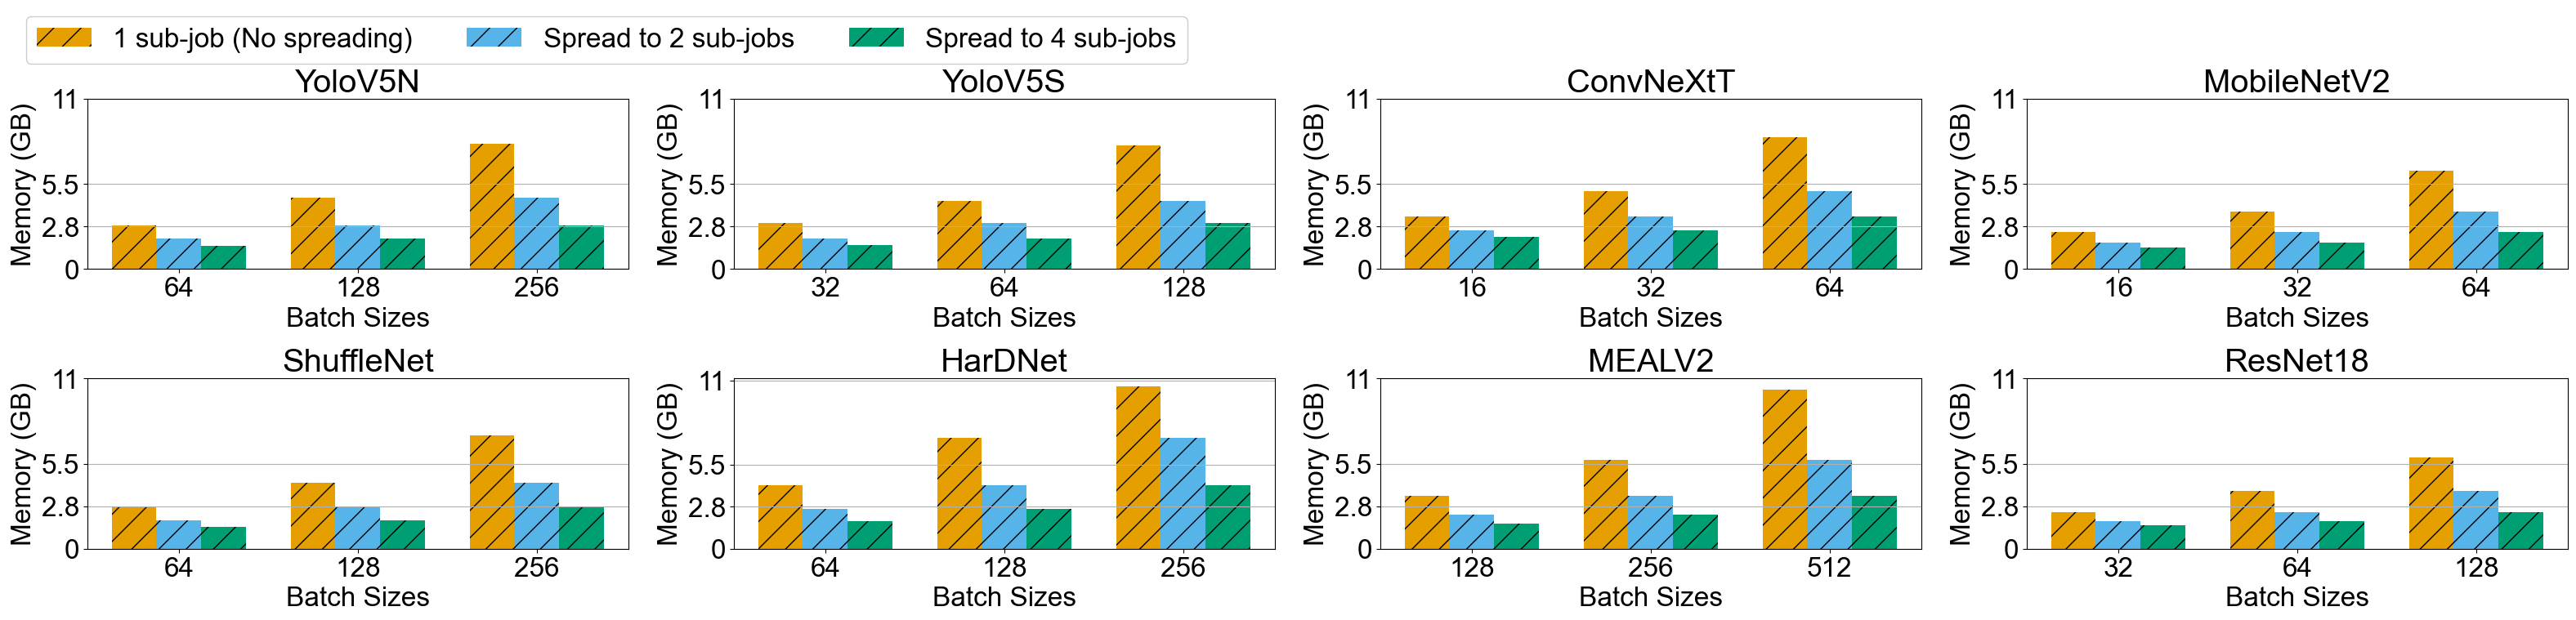

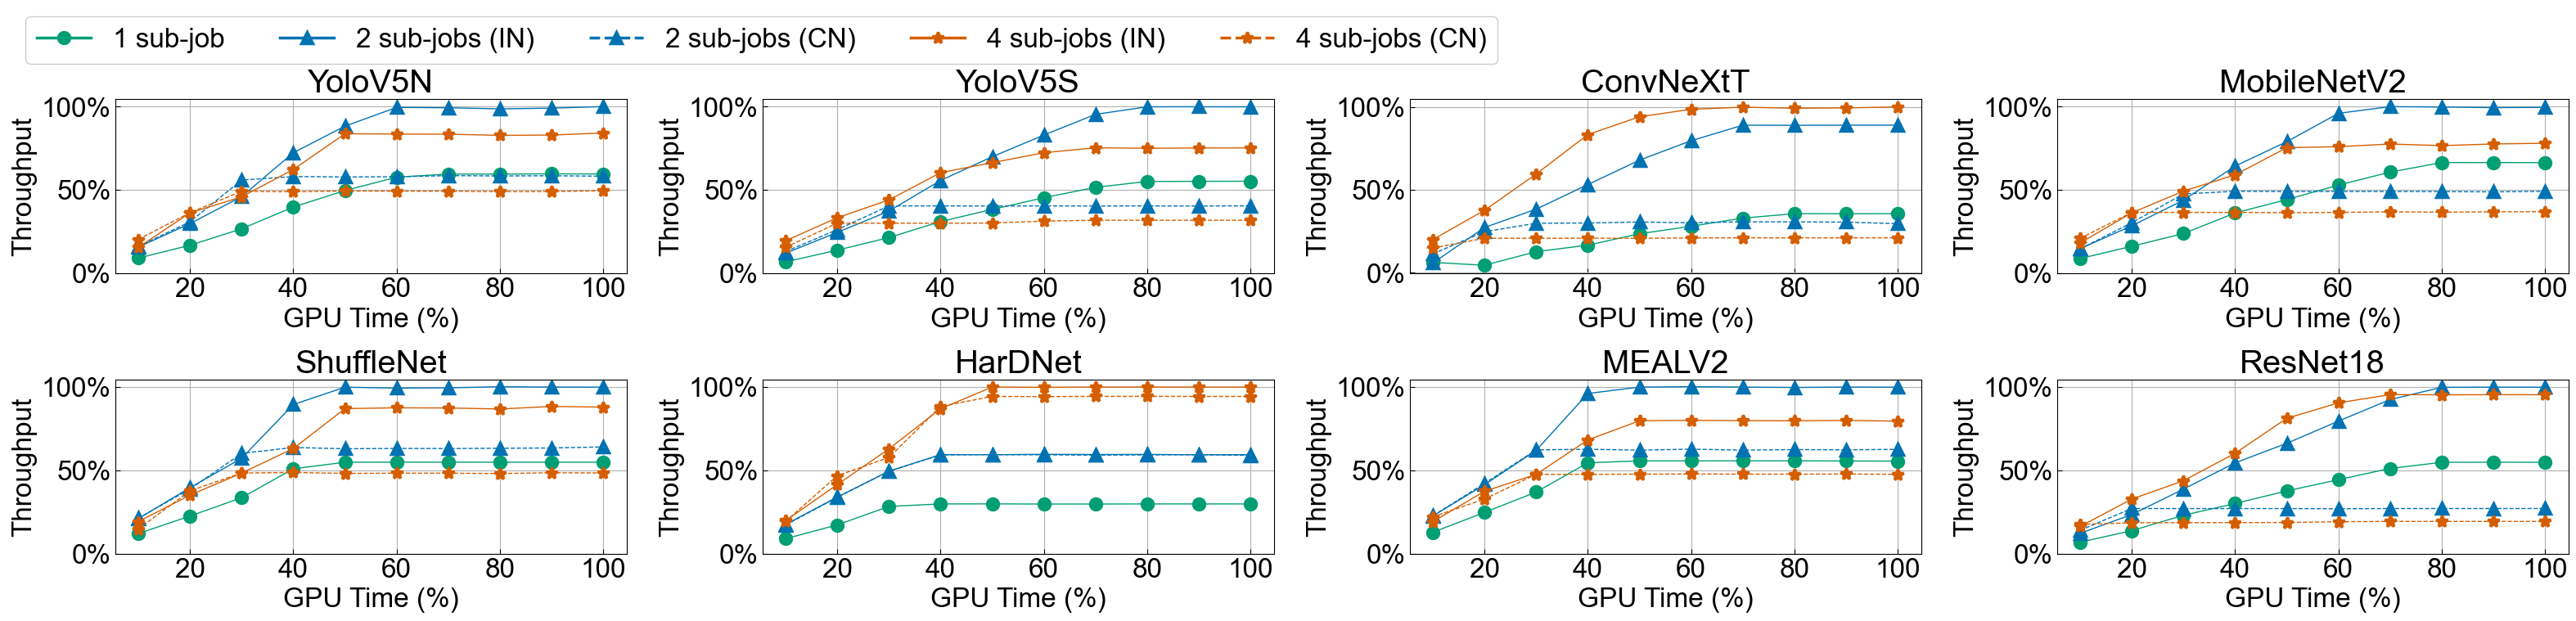

In [8]:
def plot_mono_job_performance(ax,
                              ds: DataSource,
                              model_name: ModelName,
                              exec_infos: List[MonoJobExecInfo],
                              batch_sizes: List[int]):
    model_name_to_batch_size = {
        ModelName.InceptionV3: 64,
        ModelName.EfficientNet: 64,
        ModelName.ResNet50: 64,
        ModelName.MobileNetV2: 64,
        ModelName.ConvNeXtT: 64,
        ModelName.ConvNeXtS: 64,
    }
    batch_sizes = [model_name_to_batch_size.get(model_name, 128)]
    style_specs = {  # sub_job_count to cross_node to (label, line_style, marker)
        1: {
            False: ("1 sub-job", "solid", "o", colors[2]),
        },
        2: {
            True: ("2 sub-jobs (CN)", "--", "^", colors[3]),
            False: ("2 sub-jobs (IN)", "solid", "^", colors[3])
        },
        4: {
            True: ("4 sub-jobs (CN)", "--", "*", colors[4]),
            False: ("4 sub-jobs (IN)", "solid", "*", colors[4])
        }
    }
    marker_legend_handles = list()
    for sub_job_count in [1, 2, 4]:
        cross_node_to_styles = style_specs[sub_job_count]
        for cross_node in [False, True]:
            if cross_node not in cross_node_to_styles:
                continue
            styles = cross_node_to_styles[cross_node]
            label, line_style, marker, color = styles

            marker_legend_handle = mlines.Line2D([], [],
                                                 color=color,
                                                 marker=marker,
                                                 linestyle=line_style,
                                                 label=f"{label}")
            marker_legend_handles.append(marker_legend_handle)

    def plot_spread(sub_job_count: int, cross_node: bool, maximum_performance_in_all: Optional[float] = None,
                    return_max_performance: bool = False):
        batch_size_to_performance = dict()
        gpu_type = GPUType.RTX_2080Ti
        for i, batch_size in enumerate(batch_sizes):
            iteration_intervals = list()
            for comp in range(10, 110, 10):
                iter_time = ds.iteration_time_nano(model_name=model_name, batch_size=batch_size, GPU_type=gpu_type,
                                                   worker_count=sub_job_count, cross_node=cross_node,
                                                   comp_req=to_normalized_comp(comp))
                iteration_intervals.append(iter_time)
            iteration_intervals = np.array(iteration_intervals, dtype=float)
            iteration_intervals /= 1e9
            # normalized_performances = np.min(iteration_intervals) / iteration_intervals
            normalized_performances = 1 / iteration_intervals
            batch_size_to_performance[batch_size] = normalized_performances

        maximum_performance = 0
        for performances in batch_size_to_performance.values():
            maximum_performance = max(max(performances), maximum_performance)

        if return_max_performance:
            return maximum_performance

        assert maximum_performance_in_all is not None
        for batch_size in batch_sizes:
            x_range = np.arange(10, 110, step=10)
            # normalized_performances = batch_size_to_performance[batch_size] / np.max(batch_size_to_performance[batch_size])
            normalized_performances = batch_size_to_performance[batch_size] / maximum_performance_in_all
            label_, line_style_, marker_, color_ = style_specs[sub_job_count][cross_node]
            ax.plot(x_range, normalized_performances,
                    marker=marker_,
                    linestyle=line_style_,
                    linewidth='1',
                    color=color_)

    specs = [
        (1, False),
        (2, False),
        (2, True),
        (4, False),
        (4, True)
    ]
    max_perf = None
    for spec in specs:
        worker_count, cross_node = spec
        p = plot_spread(worker_count, cross_node, return_max_performance=True)
        if max_perf is None or p > max_perf:
            max_perf = p

    for spec in specs:
        worker_count, cross_node = spec
        plot_spread(worker_count, cross_node, maximum_performance_in_all=max_perf)

    batch_size_legend_handles = list()
    # for i, batch_size in enumerate([16, 32, 64, 128, 256, 512]):
    #     handle = mlines.Line2D([], [],
    #                            marker="s",
    #                            linestyle="None",
    #                            label=rf"bs. {batch_size}",
    #                            color=batch_size_color(batch_size))
    #     batch_size_legend_handles.append(handle)
    legend_handles = batch_size_legend_handles + marker_legend_handles

    inside_ticks(ax=ax, x=True, y=True)
    ax.set_yticks([0, 0.5, 1])
    ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    # inside_ticks(ax)
    ax.set_xlabel(f'GPU Time (%)')
    ax.set_title(f'{model_name.name}')
    ax.set_ylabel('Throughput')
    return legend_handles


def plot_mono_jobs_performance(mono_job_exec_infos: Dict[ModelName, List[MonoJobExecInfo]],
                               show_model_batch_sizes: Dict[ModelName, List[int]],
                               model_sort: List[ModelName]):
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    col = grid_plot_col
    # row = grid_plot_row
    row = math.ceil(len(model_sort) / col)
    fig, axes = plt.subplots(row, col, figsize=(32, 8))

    handles = None
    ds = get_data_source()
    for i, model_name in enumerate(model_sort):
        batch_sizes = show_model_batch_sizes[model_name]
        exec_infos = mono_job_exec_infos[model_name]
        new_handles = plot_mono_job_performance(axes[i // col, i % col], ds, model_name, exec_infos, batch_sizes)
        if handles is None or len(new_handles) > len(handles):
            handles = new_handles
    lgd = fig.legend(handles=handles, loc=grid_plot_legend_pot, ncol=len(handles))
    lgd.get_frame().set_alpha(None)
    fig.tight_layout()
    fig.subplots_adjust(top=grid_plot_top)
    save_fig(fig, output_path(f"job_performance_diff_GPU_time.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_mono_jobs_memory(mono_job_exec_infos: Dict[ModelName, List[MonoJobExecInfo]],
                          train_or_inference: TrainOrInference):
    fig, ax = plt.subplots(figsize=(10, 4))
    labels = [model_name.name for model_name in ModelName]

    batch_size_level_to_model_to_memory = defaultdict(dict)
    for model_name in ModelName:
        exec_infos = mono_job_exec_infos[model_name]
        exec_infos = MonoJobExecInfoLoader.extract(exec_infos, train_or_inference=train_or_inference,
                                                   GPU_type=GPUType.RTX_2080Ti, worker_count=1)
        batch_sizes = MonoJobExecInfoLoader.batch_sizes(exec_infos)
        for i, batch_size in enumerate(batch_sizes):
            same_batch_size_infos = MonoJobExecInfoLoader.extract(exec_infos, batch_size=batch_size)
            memory_consumption = most([info.most_memory_consumption for info in same_batch_size_infos])
            batch_size_level_to_model_to_memory[i][model_name] = memory_consumption / GBi
    max_batch_size_level = len(batch_size_level_to_model_to_memory)
    batch_size_level_to_memory_list = dict()
    for batch_size_level in range(max_batch_size_level):
        model_to_memory = batch_size_level_to_model_to_memory[batch_size_level]
        model_memory_list = [model_to_memory.get(model_name, 0) for model_name in ModelName]
        batch_size_level_to_memory_list[batch_size_level] = np.array(model_memory_list)
    for batch_size_level in reversed(range(max_batch_size_level)):
        if batch_size_level - 1 >= 0:
            batch_size_level_to_memory_list[batch_size_level] -= batch_size_level_to_memory_list[batch_size_level - 1]
            batch_size_level_to_memory_list[batch_size_level] = batch_size_level_to_memory_list[batch_size_level].clip(
                min=0)
    for batch_size_level in range(max_batch_size_level):
        y = batch_size_level_to_memory_list[batch_size_level]
        minor_y = np.zeros_like(y)
        for minor_batch_size_level in range(batch_size_level):
            minor_y += batch_size_level_to_memory_list[minor_batch_size_level]
        ax.bar(labels, y, width=0.3, bottom=minor_y, color=batch_size_level_color(batch_size_level))

    ax.yaxis.grid(True)
    ax.set_xlabel("Models")
    ax.set_ylabel("Memory Consumption (GBi)")
    ax.legend([rf"$bs. {2 ** level} \times$" for level in range(max_batch_size_level)], loc=[0.2, 0.45])
    for bars in ax.containers:
        values = ["%.2f" % value if value > 0 else "" for value in bars.datavalues]
        ax.bar_label(bars, labels=values, label_type="center", fontsize=6)
    # ax.set_title("Memory")
    save_fig(fig, output_path(f"mono_job_{train_or_inference.name}_memories.pdf"))


def plot_mono_job_memory_spread_compare(ax,
                                        model_name: ModelName,
                                        exec_infos: List[MonoJobExecInfo],
                                        gpu_type: GPUType,
                                        worker_counts: Tuple[int, int, int],
                                        batch_sizes: List[int]
                                        ):
    worker_count_to_spreading_label = {
        1: "1 sub-job (No spreading)",
        2: "Spread to 2 sub-jobs",
        4: "Spread to 4 sub-jobs"
    }
    worker_counts_specs = [('local', worker_counts[0], 0, 0),  # comp, dist or local, worker_count, idx, color_idx
                           ('dist_0', worker_counts[1], 0, 1),
                           ('dist_1', worker_counts[2], 0, 2)]
    exec_infos = MonoJobExecInfoLoader.extract(exec_infos, train_or_inference=TrainOrInference.train)
    # local_comp_to_diff_bs_overhead = defaultdict(list)
    local_worker_count_to_diff_bs_mem = defaultdict(list)
    # idx_to_dist_comp_to_diff_bs_overhead = defaultdict(lambda :defaultdict(list))
    idx_to_worker_count_to_diff_bs_mem = defaultdict(lambda: defaultdict(list))
    gpu_exec_infos = MonoJobExecInfoLoader.extract(exec_infos, GPU_type=gpu_type)
    for worker_count_spec in worker_counts_specs:
        local_or_dist, worker_count, idx, _ = worker_count_spec
        local = local_or_dist == "local"
        comp_exec_infos = MonoJobExecInfoLoader.extract(gpu_exec_infos,
                                                        computation_proportion_predicate=lambda cp: cp == 50,
                                                        worker_count=1)
        for i, batch_size in enumerate(batch_sizes):
            batch_size //= worker_count
            info = MonoJobExecInfoLoader.extract(infos=comp_exec_infos, batch_size=batch_size)
            local_info = MonoJobExecInfoLoader.extract(infos=comp_exec_infos, batch_size=int(batch_size * worker_count))
            assert len(info) == 1
            assert len(local_info) == 1
            info = info[0]
            local_info = local_info[0]
            curr_mem = info.most_memory_consumption
            if worker_count == 1:
                local_worker_count_to_diff_bs_mem[worker_count].append(
                    (info.most_memory_consumption, 1.0))
            else:
                standard_mem = local_info.most_memory_consumption
                mem_proportion = curr_mem / standard_mem
                idx_to_worker_count_to_diff_bs_mem[idx][worker_count].append(
                    (curr_mem, mem_proportion))

    print(f"{model_name}", local_worker_count_to_diff_bs_mem)
    print(f"{model_name}", idx_to_worker_count_to_diff_bs_mem)

    N = len(batch_sizes)
    ind = np.arange(N)
    width = 0.25

    performance_bar_legend_artists = list()
    performance_bars = list()
    local_hatch = r"/"
    dist_hatches = [r"*", r"o"]
    edgecolor = None

    for i, worker_count_spec in enumerate(worker_counts_specs):
        local_or_dist, worker_count, idx, color_idx = worker_count_spec
        local = local_or_dist == "local"
        worker_count_to_diff_bs_mem = local_worker_count_to_diff_bs_mem if local else \
            idx_to_worker_count_to_diff_bs_mem[idx]
        diff_bs_mem = worker_count_to_diff_bs_mem[worker_count]
        normalized_mem = np.array([p[-1] for p in diff_bs_mem])
        # GPU_label = f"{worker_count} GPU"
        spreading_label = worker_count_to_spreading_label[worker_count]
        spreading_color = colors[color_idx]
        if local:
            hatch = local_hatch
        else:
            hatch = dist_hatches[int(local_or_dist.split("_")[-1])]
        performance_bars.append(ax.bar(
            ind + i * width,
            normalized_mem,
            edgecolor=edgecolor,
            width=width,
            color=spreading_color,
            label=spreading_label,
            hatch=hatch
        ))
        handle = Patch(
            facecolor=spreading_color,
            edgecolor=edgecolor,
            label=spreading_label,
            hatch=hatch
        )
        performance_bar_legend_artists.append(handle)
    ax.set_xlabel(f"Batch Sizes")
    ax.set_title(f"{model_name.name}")
    ax.set_ylabel('Memory')
    ax.set_xticks(ind + (len(worker_counts_specs) - 1) / 2 * width, [str(bs) for bs in batch_sizes])
    ax.set_yticks([0, 0.25, 0.5, 1])
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    return performance_bar_legend_artists


def plot_mono_job_memory_spread_compare_absolute(ax,
                                                 model_name: ModelName,
                                                 exec_infos: List[MonoJobExecInfo],
                                                 gpu_type: GPUType,
                                                 worker_counts: Tuple[int, int, int],
                                                 batch_sizes: List[int]
                                                 ):
    worker_count_to_spreading_label = {
        1: "1 sub-job (No spreading)",
        2: "Spread to 2 sub-jobs",
        4: "Spread to 4 sub-jobs"
    }
    worker_counts_specs = [('local', worker_counts[0], 0, 0),  # comp, dist or local, worker_count, idx, color_idx
                           ('dist_0', worker_counts[1], 0, 1),
                           ('dist_1', worker_counts[2], 0, 2)]
    exec_infos = MonoJobExecInfoLoader.extract(exec_infos, train_or_inference=TrainOrInference.train)
    # local_comp_to_diff_bs_overhead = defaultdict(list)
    local_worker_count_to_diff_bs_mem = defaultdict(list)
    # idx_to_dist_comp_to_diff_bs_overhead = defaultdict(lambda :defaultdict(list))
    idx_to_worker_count_to_diff_bs_mem = defaultdict(lambda: defaultdict(list))
    gpu_exec_infos = MonoJobExecInfoLoader.extract(exec_infos, GPU_type=gpu_type)
    for worker_count_spec in worker_counts_specs:
        local_or_dist, worker_count, idx, _ = worker_count_spec
        local = local_or_dist == "local"
        comp_exec_infos = MonoJobExecInfoLoader.extract(gpu_exec_infos,
                                                        computation_proportion_predicate=lambda cp: cp == 50,
                                                        worker_count=1)
        for i, batch_size in enumerate(batch_sizes):
            batch_size //= worker_count
            info = MonoJobExecInfoLoader.extract(infos=comp_exec_infos, batch_size=batch_size)
            local_info = MonoJobExecInfoLoader.extract(infos=comp_exec_infos, batch_size=int(batch_size * worker_count))
            assert len(info) == 1
            assert len(local_info) == 1
            info = info[0]
            local_info = local_info[0]
            curr_mem = info.most_memory_consumption
            if worker_count == 1:
                local_worker_count_to_diff_bs_mem[worker_count].append(
                    (info.most_memory_consumption, info.most_memory_consumption / GBi))
            else:
                idx_to_worker_count_to_diff_bs_mem[idx][worker_count].append(
                    (curr_mem, curr_mem / GBi))

    print(f"{model_name}", local_worker_count_to_diff_bs_mem)
    print(f"{model_name}", idx_to_worker_count_to_diff_bs_mem)

    N = len(batch_sizes)
    ind = np.arange(N)
    width = 0.25

    performance_bar_legend_artists = list()
    performance_bars = list()
    local_hatch = r"/"
    dist_hatches = [r"/", r"/"]
    edgecolor = None

    for i, worker_count_spec in enumerate(worker_counts_specs):
        local_or_dist, worker_count, idx, color_idx = worker_count_spec
        local = local_or_dist == "local"
        worker_count_to_diff_bs_mem = local_worker_count_to_diff_bs_mem if local else \
            idx_to_worker_count_to_diff_bs_mem[idx]
        diff_bs_mem = worker_count_to_diff_bs_mem[worker_count]
        normalized_mem = np.array([p[-1] for p in diff_bs_mem])
        # GPU_label = f"{worker_count} GPU"
        spreading_label = worker_count_to_spreading_label[worker_count]
        spreading_color = colors[color_idx]
        if local:
            hatch = local_hatch
        else:
            hatch = dist_hatches[int(local_or_dist.split("_")[-1])]
        performance_bars.append(ax.bar(
            ind + i * width,
            normalized_mem,
            edgecolor=edgecolor,
            width=width,
            color=spreading_color,
            label=spreading_label,
            hatch=hatch
        ))
        handle = Patch(
            facecolor=spreading_color,
            edgecolor=edgecolor,
            label=spreading_label,
            hatch=hatch
        )
        performance_bar_legend_artists.append(handle)
    ax.set_xlabel(f"Batch Sizes")
    ax.set_title(f"{model_name.name}")
    ax.set_ylabel('Memory (GB)')
    ax.set_xticks(ind + (len(worker_counts_specs) - 1) / 2 * width, [str(bs) for bs in batch_sizes])
    ax.set_yticks([0, 0.25 * 11, 0.5 * 11, 11])
    ax.yaxis.grid(True)
    # ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{:.2f}'.format))
    ax.yaxis.set_major_formatter(
        plt_ticker.FuncFormatter(lambda v, pos: '{:2.1f}'.format(v) if v != round(v) else int(v)))
    return performance_bar_legend_artists


def plot_mono_jobs_memory_spread_compare(mono_job_exec_infos: Dict[ModelName, List[MonoJobExecInfo]],
                                         show_model_batch_sizes: Dict[ModelName, List[int]],
                                         model_sort: List[ModelName],
                                         absolute: bool = False):
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': grid_plot_font})
    col = grid_plot_col
    # row = grid_plot_row
    row = math.ceil(len(model_sort) / col)
    fig, axes = plt.subplots(row, col, figsize=(grid_plot_width, grid_plot_height))

    handles = None
    gpu_type = GPUType.RTX_2080Ti
    for i, model_name in enumerate(model_sort):
        batch_sizes = show_model_batch_sizes[model_name]
        exec_infos = mono_job_exec_infos[model_name]
        if absolute:
            new_handles = plot_mono_job_memory_spread_compare_absolute(axes[i // col, i % col], model_name, exec_infos,
                                                                       gpu_type,
                                                                       worker_counts=(1, 2, 4), batch_sizes=batch_sizes)
        else:
            new_handles = plot_mono_job_memory_spread_compare(axes[i // col, i % col], model_name, exec_infos, gpu_type,
                                                              worker_counts=(1, 2, 4), batch_sizes=batch_sizes)
        if handles is None:
            handles = new_handles
    fig.tight_layout()
    lgd = fig.legend(handles=handles, loc=grid_plot_legend_pot, ncol=len(handles))
    lgd.get_frame().set_alpha(None)
    # fig.suptitle(f"Memory Quotas of Workers With Various Spreading Configurations", fontsize="x-large")
    fig.subplots_adjust(top=0.83)
    # fig.show()
    if absolute:
        file_name = "job_dist_memory_absolute.pdf"
    else:
        file_name = "job_dist_memory.pdf"
    fig.savefig(output_path(file_name), dpi=400, format='pdf', bbox_inches='tight')
    mpl.rcParams.update({'font.size': original_fontsize})


def get_communication_overhead(exec_infos: List[MonoJobExecInfo], batch_size: int, worker_count: int):
    local_50 = MonoJobExecInfoLoader.extract(exec_infos, batch_size=batch_size, GPU_type=GPUType.RTX_2080Ti,
                                             worker_count=1,
                                             computation_proportion_predicate=lambda cp: cp == 50)
    dist_50 = MonoJobExecInfoLoader.extract(exec_infos, batch_size=batch_size, GPU_type=GPUType.RTX_2080Ti,
                                            worker_count=worker_count,
                                            computation_proportion_predicate=lambda cp: cp == 50)
    overhead = dist_50[0].avg_stabled_iteration_interval - local_50[0].avg_stabled_iteration_interval
    return overhead


def plot_mono_job_dist_performance(ax,
                                   model_name: ModelName,
                                   exec_infos: List[MonoJobExecInfo],
                                   gpu_type: GPUType,
                                   batch_sizes: List[int],
                                   comps: Tuple[int, int, int, int, int] = (100, 50, 60, 25, 30),
                                   ):
    computation_proportions = [(comps[0], 'local', 1, 0, 0),  # comp, dist or local, worker_count, idx, color_idx
                               (comps[1], 'dist_0', 2, 0, 1),
                               (comps[2], 'dist_1', 2, 0, 2),
                               (comps[3], 'dist_2', 4, 0, 3),
                               (comps[4], 'dist_3', 4, 0, 4),
                               ]
    exec_infos = MonoJobExecInfoLoader.extract(exec_infos, train_or_inference=TrainOrInference.train)
    local_comp_to_diff_bs_overhead = defaultdict(list)
    local_comp_to_diff_bs_performance = defaultdict(list)
    idx_to_dist_comp_to_diff_bs_overhead = defaultdict(lambda: defaultdict(list))
    idx_to_dist_comp_to_diff_bs_performance = defaultdict(lambda: defaultdict(list))
    gpu_exec_infos = MonoJobExecInfoLoader.extract(exec_infos, GPU_type=gpu_type)
    for computation_proportion in computation_proportions:
        comp, local_or_dist, worker_count, idx, _ = computation_proportion
        local = local_or_dist == "local"
        if local and comp in local_comp_to_diff_bs_performance:
            continue
        comp_exec_infos = MonoJobExecInfoLoader.extract(gpu_exec_infos,
                                                        computation_proportion_predicate=lambda cp: cp == comp,
                                                        worker_count=worker_count)
        local_comp_exec_infos = MonoJobExecInfoLoader.extract(gpu_exec_infos,
                                                              computation_proportion_predicate=lambda cp: cp == comp,
                                                              worker_count=1)
        for i, batch_size in enumerate(batch_sizes):
            batch_size //= worker_count
            info = MonoJobExecInfoLoader.extract(infos=comp_exec_infos, batch_size=batch_size)
            local_info = MonoJobExecInfoLoader.extract(infos=local_comp_exec_infos, batch_size=batch_size)
            assert len(info) == 1
            assert len(local_info) == 1
            info = info[0]
            curr_performance = info.avg_stabled_iteration_interval
            local_iteration_interval = local_info[0].avg_stabled_iteration_interval
            overhead = curr_performance - local_iteration_interval
            if overhead < 0:
                overhead = curr_performance * 0.005
            if worker_count == 1:
                local_comp_to_diff_bs_performance[comp].append(
                    (info.avg_stabled_iteration_interval, 1.0))
                local_comp_to_diff_bs_overhead[comp].append(
                    (0, 0.))
            else:
                standard_performance = None
                for cp in computation_proportions:
                    other_comp, other_local_or_dist, _, other_idx, _ = cp
                    if other_idx == idx and other_local_or_dist == "local":
                        standard_performance, _ = local_comp_to_diff_bs_performance[other_comp][i]
                        break
                assert standard_performance is not None
                normalized_performance = standard_performance / curr_performance
                idx_to_dist_comp_to_diff_bs_performance[idx][comp].append(
                    (curr_performance, normalized_performance))
                idx_to_dist_comp_to_diff_bs_overhead[idx][comp].append(
                    (overhead, overhead / curr_performance)
                )

    print(f"{model_name}", local_comp_to_diff_bs_performance)
    print(f"{model_name}", local_comp_to_diff_bs_overhead)
    print(f"{model_name}", idx_to_dist_comp_to_diff_bs_performance)
    print(f"{model_name}", idx_to_dist_comp_to_diff_bs_overhead)

    N = len(batch_sizes)
    ind = np.arange(N)
    width = 0.17

    overhead_bar_legend_artist_list = list()
    performance_bar_legend_artists = list()
    overhead_bars = list()
    performance_bars = list()
    local_hatch = r"/"
    dist_hatches = [r"/", r"/", "/", "/"]
    edgecolor = None

    ax_overhead = ax.twinx()
    ax_overhead.set_ylim([0., 1.])
    ax_overhead_ylabel = "Comm. Overhead"
    # fontsize = 24
    ax_overhead.set_ylabel(ax_overhead_ylabel)
    overhead_linestyle = "--"
    overhead_marker = "*"
    overhead_marker_size = 10
    overhead_linewidth = "4"
    overhead_bar_legend_artist = mlines.Line2D(
        [], [],
        linestyle=overhead_linestyle,
        linewidth=overhead_linewidth,
        marker=overhead_marker,
        markersize=overhead_marker_size,
        label=ax_overhead_ylabel,
        color="black"
    )
    overhead_bar_legend_artist_list.append(overhead_bar_legend_artist)
    for i, computation_proportion in enumerate(computation_proportions):
        comp, local_or_dist, worker_count, idx, color_idx = computation_proportion
        local = local_or_dist == "local"
        comp_to_diff_bs_overhead = local_comp_to_diff_bs_overhead if local else idx_to_dist_comp_to_diff_bs_overhead[
            idx]
        comp_to_diff_bs_performance = local_comp_to_diff_bs_performance if local else \
            idx_to_dist_comp_to_diff_bs_performance[idx]
        diff_bs_overhead = comp_to_diff_bs_overhead[comp]
        diff_bs_performance = comp_to_diff_bs_performance[comp]
        normalized_overheads = np.array([o[-1] for o in diff_bs_overhead])
        normalized_performances = np.array([p[-1] for p in diff_bs_performance])
        overhead_bar_color = colors[color_idx]
        if local_or_dist != "local":
            overhead_bars.append(ax_overhead.plot(
                ind + i * width,
                normalized_overheads,
                linestyle=overhead_linestyle,
                linewidth=overhead_linewidth,
                marker=overhead_marker,
                markersize=overhead_marker_size,
                mfc=overhead_bar_color,
                mec='black',
                color=overhead_bar_color,
                label=ax_overhead_ylabel,
            ))
        performance_label = f"{worker_count} sub-job {comp}% comp." if worker_count == 1 else f"{worker_count} sub-jobs {comp}% comp."
        performance_color = colors[color_idx]
        if local:
            hatch = local_hatch
        else:
            hatch = dist_hatches[int(local_or_dist.split("_")[-1])]
        performance_bars.append(ax.bar(
            ind + i * width,
            normalized_performances,
            edgecolor=edgecolor,
            width=width,
            color=performance_color,
            label=performance_label,
            hatch=hatch
        ))
        handle = Patch(
            facecolor=performance_color,
            edgecolor=edgecolor,
            label=performance_label,
            hatch=hatch
        )
        performance_bar_legend_artists.append(handle)
    ax.set_xlabel(f"Batch Sizes")
    ax.set_title(f'{model_name.name}')
    ax.set_ylabel('Performance')
    ax.set_xticks(ind + (len(computation_proportions) - 1) / 2 * width, [str(bs) for bs in batch_sizes])
    ax.set_yticks([0, 0.5, 1])
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    ax_overhead.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    return performance_bar_legend_artists + overhead_bar_legend_artist_list


def plot_mono_job_spread_performance(ax,
                                     model_name: ModelName,
                                     exec_infos: List[MonoJobExecInfo],
                                     gpu_type: GPUType,
                                     batch_sizes: List[int],
                                     original_comp: Optional[int] = None,
                                     ):
    class BarMeta:
        def __init__(self, name: str, original: bool, worker_count: int, cross_node: bool, color_idx: int):
            self.name: str = name
            self.original: bool = original
            self.worker_count: int = worker_count
            self.cross_node: bool = cross_node
            self.color_idx: int = color_idx

    bar_groups = [BarMeta(name="original", original=True, worker_count=1, cross_node=False, color_idx=0),
                  # comp, dist or local, worker_count, idx, color_idx
                  BarMeta(name="spread_2_in", original=False, worker_count=2, cross_node=False, color_idx=1),
                  BarMeta(name="spread_2_cross", original=False, worker_count=2, cross_node=True, color_idx=2),
                  BarMeta(name="spread_4_in", original=False, worker_count=4, cross_node=False, color_idx=3),
                  BarMeta(name="spread_4_cross", original=False, worker_count=4, cross_node=True, color_idx=4), ]

    original_bs_to_max_perf_comp = dict()
    original_bar_meta = bar_groups[0]
    ds = get_data_source()

    def get_bar_meta_comp(bar_meta: BarMeta, batch_size: int) -> Optional[int]:
        nonlocal original_comp
        if bar_meta.original:
            if original_comp != None:
                original_bs_to_max_perf_comp[batch_size] = original_comp
                return original_comp
            if batch_size in original_bs_to_max_perf_comp:
                return original_bs_to_max_perf_comp[batch_size]
            original_comp_iter_max = 1. / ds.iteration_time_nano(model_name=model_name, batch_size=batch_size,
                                                                 GPU_type=gpu_type,
                                                                 worker_count=original_bar_meta.worker_count,
                                                                 cross_node=original_bar_meta.cross_node,
                                                                 comp_req=CompCapacity)
            k = original_comp_iter_max / CompCapacity
            target_original_comp_req = 2
            for comp_req in range(2, CompCapacity):
                curr_iter = 1. / ds.iteration_time_nano(model_name=model_name, batch_size=batch_size, GPU_type=gpu_type,
                                                        worker_count=original_bar_meta.worker_count,
                                                        cross_node=original_bar_meta.cross_node,
                                                        comp_req=comp_req)
                prev_iter = 1. / ds.iteration_time_nano(model_name=model_name, batch_size=batch_size, GPU_type=gpu_type,
                                                        worker_count=original_bar_meta.worker_count,
                                                        cross_node=original_bar_meta.cross_node,
                                                        comp_req=comp_req - 1)
                neighbor_k = curr_iter - prev_iter
                if neighbor_k < k:
                    target_original_comp_req = comp_req
                    break
            original_comp_ = to_real_comp(target_original_comp_req)
            original_bs_to_max_perf_comp[batch_size] = original_comp_
            return original_comp_

        original_comp_ = original_bs_to_max_perf_comp[batch_size]

        original_comp_req = to_normalized_comp(original_comp_)
        base_comp_req = original_comp_req // bar_meta.worker_count
        target_comp_req = base_comp_req
        original_iteration_time = ds.iteration_time_nano(model_name=model_name, batch_size=batch_size,
                                                         GPU_type=gpu_type,
                                                         worker_count=original_bar_meta.worker_count,
                                                         cross_node=original_bar_meta.cross_node,
                                                         comp_req=original_comp_req)
        while target_comp_req <= CompCapacity:
            curr_iteration_time = ds.iteration_time_nano(model_name=model_name, batch_size=batch_size,
                                                         GPU_type=gpu_type,
                                                         worker_count=bar_meta.worker_count,
                                                         cross_node=bar_meta.cross_node, comp_req=target_comp_req)
            if curr_iteration_time > original_iteration_time:
                target_comp_req += 1
            else:
                break
        if target_comp_req > CompCapacity:
            return 0
        return to_real_comp(target_comp_req)

    bar_meta_diff_bs_comps = defaultdict(list)
    for bar_meta in bar_groups:
        diff_bs_comps = list()
        for i, batch_size in enumerate(batch_sizes):
            comp = get_bar_meta_comp(bar_meta, batch_size=batch_size)
            diff_bs_comps.append(comp)
        bar_meta_diff_bs_comps[bar_meta.name] = diff_bs_comps

    print(f"{model_name} diff_bs_comps", bar_meta_diff_bs_comps)

    N = len(batch_sizes)
    ind = np.arange(N)
    width = 0.17

    comp_bar_legend_artists = list()
    comp_bars = list()
    hatch = r"/"
    edgecolor = None

    for i, bar_meta in enumerate(bar_groups):
        is_original, worker_count, cross_node, color_idx = bar_meta.original, bar_meta.worker_count, bar_meta.cross_node, bar_meta.color_idx
        diff_bs_comps = bar_meta_diff_bs_comps[bar_meta.name]

        comp_label = f"{worker_count} sub-job" if worker_count == 1 else f"{worker_count} sub-jobs"
        if worker_count > 1:
            comp_label += " (CN)" if cross_node else " (IN)"
        comp_color = colors[color_idx]
        comp_bars.append(ax.bar(
            ind + i * width,
            diff_bs_comps,
            edgecolor=edgecolor,
            width=width,
            color=comp_color,
            label=comp_label,
            hatch=hatch
        ))
        handle = Patch(
            facecolor=comp_color,
            edgecolor=edgecolor,
            label=comp_label,
            hatch=hatch
        )
        comp_bar_legend_artists.append(handle)
    ax.set_xlabel(f"Batch Sizes")
    ax.set_title(f'{model_name.name}')
    ax.set_ylabel('Comp. Resource')
    ax.set_xticks(ind + (len(bar_groups) - 1) / 2 * width, [str(bs) for bs in batch_sizes])
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_major_formatter('{x:.0f}%')
    # ax.set_yticks([0, 50, 100])
    ax.yaxis.grid(True)
    # ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{}%'.format))
    # ax_overhead.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    # return performance_bar_legend_artists + overhead_bar_legend_artist_list
    return comp_bar_legend_artists


def plot_mono_jobs_dist_performance_spread(mono_job_exec_infos: Dict[ModelName, List[MonoJobExecInfo]],
                                           show_model_batch_sizes: Dict[ModelName, List[int]],
                                           model_sort: List[ModelName],
                                           original_comp: Optional[int]):
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': grid_plot_font})
    col = grid_plot_col
    # row = grid_plot_row
    row = math.ceil(len(model_sort) / col)
    fig, axes = plt.subplots(row, col, figsize=(grid_plot_width, grid_plot_height))

    handles = None
    gpu_type = GPUType.RTX_2080Ti
    for i, model_name in enumerate(model_sort):
        batch_sizes = show_model_batch_sizes[model_name]
        exec_infos = mono_job_exec_infos[model_name]
        new_handles = plot_mono_job_spread_performance(axes[i // col, i % col], model_name, exec_infos, gpu_type,
                                                       batch_sizes=batch_sizes, original_comp=original_comp)
        if handles is None:
            handles = new_handles
    fig.tight_layout()
    lgd = fig.legend(handles=handles, loc=grid_plot_legend_pot, ncol=len(handles))
    lgd.get_frame().set_alpha(None)
    fig.subplots_adjust(top=grid_plot_top)
    fig.savefig(output_path(f"mono_job_dist_performance_spread_{original_comp}.pdf"), dpi=400, format='pdf',
                bbox_inches='tight')
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_mono_jobs_dist_performance(mono_job_exec_infos: Dict[ModelName, List[MonoJobExecInfo]],
                                    show_model_batch_sizes: Dict[ModelName, List[int]],
                                    model_sort: List[ModelName],
                                    comps: Tuple):
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': grid_plot_font})
    col = grid_plot_col
    row = grid_plot_row
    fig, axes = plt.subplots(row, col, figsize=(grid_plot_width, grid_plot_height))

    handles = None
    gpu_type = GPUType.RTX_2080Ti
    for i, model_name in enumerate(model_sort):
        batch_sizes = show_model_batch_sizes[model_name]
        exec_infos = mono_job_exec_infos[model_name]
        new_handles = plot_mono_job_dist_performance(axes[i // col, i % col], model_name, exec_infos, gpu_type,
                                                     batch_sizes=batch_sizes, comps=comps)
        if handles is None:
            handles = new_handles
    fig.tight_layout()
    lgd = fig.legend(handles=handles, loc=grid_plot_legend_pot, ncol=len(handles))
    lgd.get_frame().set_alpha(None)
    fig.subplots_adjust(top=grid_plot_top)
    fig.savefig(output_path(f"mono_job_dist_performance_{comps[0]}.pdf"), dpi=400, format='pdf',
                bbox_inches='tight')
    mpl.rcParams.update({'font.size': original_fontsize})


model_sort = [
    # ModelName.SqueezeNet,
    ModelName.YoloV5N,
    ModelName.YoloV5S,
    ModelName.ConvNeXtT,
    # ModelName.ConvNeXtS,
    # ModelName.EfficientNet,
    ModelName.MobileNetV2,
    # ModelName.MobileNetV3S,
    # ModelName.GhostNet,
    ModelName.ShuffleNet,
    ModelName.HarDNet,
    ModelName.MEALV2,
    # ModelName.InceptionV3,
    ModelName.ResNet18,
    # ModelName.ResNet50,
]
show_model_batch_sizes = {
    ModelName.ConvNeXtT: [16, 32, 64],
    ModelName.ConvNeXtS: [16, 32, 64],
    ModelName.SqueezeNet: [64, 128, 256],
    ModelName.YoloV5S: [32, 64, 128],
    ModelName.YoloV5N: [64, 128, 256],
    ModelName.MobileNetV2: [16, 32, 64],
    ModelName.MobileNetV3S: [64, 128, 256],
    ModelName.EfficientNet: [16, 32, 64],
    ModelName.GhostNet: [64, 128, 256],
    ModelName.ShuffleNet: [64, 128, 256],
    ModelName.HarDNet: [64, 128, 256],
    ModelName.MEALV2: [128, 256, 512],
    ModelName.InceptionV3: [16, 32, 64],
    ModelName.ResNet18: [32, 64, 128],
    ModelName.ResNet50: [16, 32, 64],
}

plot_mono_jobs_memory_spread_compare(data_source.mono_job_data, show_model_batch_sizes=show_model_batch_sizes,
                                     model_sort=model_sort, absolute=True)
#
plot_mono_jobs_performance(data_source.mono_job_data, show_model_batch_sizes=show_model_batch_sizes,
                           model_sort=model_sort)